In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import emcee
from fit_just_early_lc import prep_light_curve

import glob

In [2]:
%matplotlib notebook

## See if first light is just a function of the time  of the first detection

In [3]:
info_path="../../forced_lightcurves/sample_lc_v2/"
salt_df = pd.read_csv(info_path + "../../Nobs_cut_salt2_spec_subtype.csv")
res = pd.read_csv('results_40percent.csv')

In [20]:
thin_by = 250
rel_flux_cutoff = 0.4
t_fl = 18

# sn = 'ZTF18abaxlpi'
sn = 'ZTF18abauprj'

t_max = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)

t_data, f_data, f_unc_data, fcqfid_data = prep_light_curve(info_path+"{}_force_phot.h5".format(sn),
                                                           t_max=t_max, 
                                                           z=z,
                                                           g_max=g_max,
                                                           r_max=r_max,
                                                           rel_flux_cutoff=rel_flux_cutoff,
                                                           flux_scale=100)

In [81]:
z_files  = glob.glob(info_path + '/big_unc/*z0*h5')

for sn in ['ZTF18aasdted', 'ZTF18abauprj', 'ZTF18abcflnz', 'ZTF18abgmcmv']:
    z_files.append(info_path + '/big_unc/{}_emcee_40percent.h5'.format(sn))

z_array = np.zeros(len(z_files))
t0_array = np.zeros_like(z_array)
t0_05 = np.zeros_like(z_array)
t0_95 = np.zeros_like(z_array)

for znum, zfile in enumerate(np.sort(z_files)):
    sn = zfile.split('/big_unc/')[1].split('_')[0]
    if 'percent' in zfile:
        z_array[znum] = salt_df.z_adopt.iloc[np.where(salt_df.name == sn)]
    else:
        z_array[znum] = float(zfile.split('_z')[1].split('.h5')[0])
    reader = emcee.backends.HDFBackend(zfile)
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    tau = reader.get_autocorr_time(tol=0)
    
    burnin = int(5*np.max(tau))
    samples = reader.get_chain(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)
    lnpost = reader.get_log_prob(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)

    t0_05[znum], t0_array[znum], t0_95[znum] = np.percentile(samples[:,0], (5, 50, 95))
    
    print(zfile, np.percentile(samples[:,[0,2,4]], 50, axis=0))

../../forced_lightcurves/sample_lc_v2//big_unc/ZTF18aasdted_emcee_40_z0.05.h5 [-17.61773702   1.05375862   0.87473791]
../../forced_lightcurves/sample_lc_v2//big_unc/ZTF18aasdted_emcee_40_z0.075.h5 [-16.59663504   0.81113545   0.52188721]
../../forced_lightcurves/sample_lc_v2//big_unc/ZTF18aasdted_emcee_40_z0.1.h5 [-14.38156308   0.35539189   0.29491077]
../../forced_lightcurves/sample_lc_v2//big_unc/ZTF18aasdted_emcee_40_z0.15.h5 [-46.92682916   0.30179171   0.3687451 ]
../../forced_lightcurves/sample_lc_v2//big_unc/ZTF18aasdted_emcee_40percent.h5 [-18.48614973   1.53390564   1.38315581]
../../forced_lightcurves/sample_lc_v2//big_unc/ZTF18abauprj_emcee_40_z0.05.h5 [-18.84785322   2.21963218   2.03500022]
../../forced_lightcurves/sample_lc_v2//big_unc/ZTF18abauprj_emcee_40_z0.075.h5 [-18.4772356    1.97493151   1.91447437]
../../forced_lightcurves/sample_lc_v2//big_unc/ZTF18abauprj_emcee_40_z0.1.h5 [-17.13252962   1.64592961   0.87707752]
../../forced_lightcurves/sample_lc_v2//big_unc/

# Plot  evolution with redshift

In [69]:
t_rise = res['t_rise_50'].values
t_rise_unc = np.vstack((res['t_rise_50'] - res['t_rise_05'],
                    res['t_rise_95'] - res['t_rise_50'])) 
alpha_g = res['alpha_g'].values
alpha_g_unc = np.vstack((res['alpha_g'] - res['alpha_g_05'],
                         res['alpha_g_95'] - res['alpha_g']))
alpha_r = res['alpha_r'].values
alpha_r_unc = np.vstack((res['alpha_r'] - res['alpha_r_05'],
                         res['alpha_r_95'] - res['alpha_r']))

In [123]:
normal = np.where((salt_df['Ia subtype'] != 'Ia-CSM') & 
                  (salt_df['Ia subtype'] != 'SC') & 
                  (salt_df['Ia subtype'] != 'SC*') & 
                  (salt_df['Ia subtype'] != '86G-like') & 
                  (salt_df['Ia subtype'] != '02cx-like'))
good = np.where(res.final_selection.values == 1)
has_host_z = np.where(salt_df.z_source != 'Msl')
low_z_good = np.where((salt_df.z_source != 'Msl') & (salt_df.z_adopt < 0.03))

normal_good = np.intersect1d(normal, good)
normal_good_host = np.intersect1d(normal_good, has_host_z)
normal_low_z = np.intersect1d(normal_good, low_z_good)

normal_plot = np.setdiff1d(normal[0], normal_good)
normal_good_plot = np.setdiff1d(normal_good, normal_good_host)
normal_good_host_plot = np.setdiff1d(normal_good_host, normal_low_z)

<IPython.core.display.Javascript object>


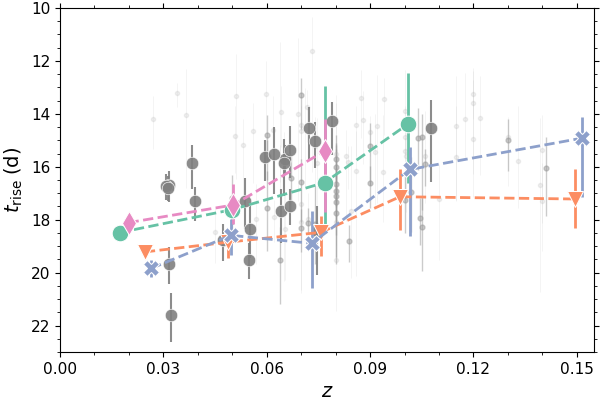

In [148]:
np.random.seed(23)

fig, ax = plt.subplots(figsize=(6,4))

#  rise vs. redshift
ax.errorbar(salt_df.z_adopt.values[normal_plot], t_rise[normal_plot], 
             yerr=t_rise_unc[:,normal_plot], fmt='.', 
              color='0.7', lw=0.5, alpha=0.2)
ax.errorbar(salt_df.z_adopt.values[normal_good_plot], t_rise[normal_good_plot], 
             yerr=t_rise_unc[:,normal_good_plot], fmt='.',
             color='0.6', lw=1, ms=7, alpha=0.5)
ax.errorbar(salt_df.z_adopt.values[normal_good_host_plot], t_rise[normal_good_host_plot], 
             yerr=t_rise_unc[:,normal_good_host_plot], fmt='o', ms=9,
             color='0.5', mec='w', mew=0.5, lw=1.5, alpha=0.9, zorder=10)

for j, col, sym in zip(range(4), 
                       ['#66c2a5','#fc8d62','#8da0cb','#e78ac3'], 
                       ['o', 'v', 'X', 'd']):
    idx = np.arange(5*j,5*(j+1))
    idx = idx[np.where(t0_array[idx] > -20)]
    
    z_data = z_array[idx] + np.random.uniform(-0.002,0.002,len(idx))
    rise = -1*t0_array[idx]
    rise_unc = np.vstack((t0_95[idx] - t0_array[idx], 
                          t0_array[idx] - t0_05[idx])) 
    
    ax.errorbar(np.sort(z_data), rise[np.argsort(z_data)],
                yerr=rise_unc[:,np.argsort(z_data)],
                fmt='{}--'.format(sym), color=col, mec='w', mew=0.75,
                ms=12, lw=2, zorder=20)


ax.set_ylabel(r'$t_\mathrm{rise}\;(\mathrm{d})$', fontsize=14)
ax.set_ylim(23,10)
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.set_xlabel(r'$z$', fontsize=14)
ax.set_xlim(0,0.155)
ax.xaxis.set_minor_locator(MultipleLocator(0.01))
ax.xaxis.set_major_locator(MultipleLocator(0.03))
ax.tick_params(top=True,right=True,which='both', labelsize=11)

fig.subplots_adjust(top=0.98,right=0.99,left=0.1,bottom=0.12)
fig.savefig('high_z_systematic.pdf')